## [Computational Social Science] Project 5: Natural Language Processing
**Group 3: Jose Aveldanes, Shruti Bathia, and Diana Casanova**

## 1. Introduction
In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#WordCloud for EDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#removing emojis
import re

#import emoji
#import scattertext as st

## 2. Data

In [2]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
numpy.random.seed(44)
congress_tweets = congress_tweets.sample(frac=0.001, random_state=1)
congress_tweets.head()
# COMPLETE - fill in this line of code with a sufficient number of tweets, depending on your computational resources
# COMPLETE congress_tweets = congress_tweets.sample(...)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## 3. Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
nlp = en_core_web_sm.load()

In [4]:
def remove_emojis(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" #emoticons  
        u"\U0001F300-\U0001F5FF" #symbols & pictographs 
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #flags(iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"   
        "]+", 
        flags=re.UNICODE,)
    return emoji_pattern.sub(r"", string)

In [5]:
congress_tweets['text_deEmojify'] = congress_tweets['text'].map(lambda x: remove_emojis(x))

In [6]:
print(congress_tweets.iloc[5]['text_deEmojify']) #checking to see if emojis were removed

RT @Johnson4Dallas This is the most accurate description of the current City of Dallas budget debate (and surrounding noise) that I have read thus far. Kudos to the author for helping to arm the residents of Dallas with actual facts instead of useless political gossip. https://texasscorecard.com/commentary/montoya-citizens-matter-not-city-hall-brawls/


In [7]:
#Removing new line
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('\n','')
#Removing New Line Breaks
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('•','')

In [8]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"amp", "RT", "today", "rt", "Today"}
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [9]:
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

217331    [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
258764    [My, Twitter, Town, Hall, healthcare, begun, I...
50091     [Scipio, Jones, ‘, fight, civil, rights, equal...
205601    [There, better, time, ActOnClimate, EarthDay, ...
85993     [I, understand, VA, problems, recruiting, qual...
                                ...                        
849015    [Thank, air, traffic, controllers, flight, att...
402238    [LawrenceGenHosp, new, coronavirus, community,...
349360    [senatemajldr, If, House, musters, courage, st...
65615     [It, important, support, policies, promote, pu...
356055    [davidmgoodwin, CDCgov, It, argument, giving, ...
Name: tokens, Length: 947, dtype: object

In [10]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

In [11]:
#lemmatization
for word in nlp(text):
    print(word.text,  word.lemma_)

Thank thank
testifying testify
Mr Mr
Blake Blake
QT QT
JRBlake JRBlake
RepValDemings repvaldeming
gave give
impassioned impassione
speech speech
place place
experience experience
having having
served serve
27 27
years year
police police
force force
     
Thank thank
My my
Twitter Twitter
Town Town
Hall Hall
healthcare healthcare
begun begin
I I
m m
answering answer
questions question
live live
Please please
hit hit
w w
AskHank AskHank
Scipio Scipio
Jones Jones
‘ '
fight fight
civil civil
rights right
equality equality
important important
Arkansas Arkansas
history history
deeply deeply
proud proud
LittleRock LittleRock
I I
like like
thank thank
GOPoversight GOPoversight
quickly quickly
marking mark
legislation legislation
pass pass
House House
Floor Floor
22 22
There there
better well
time time
ActOnClimate actonclimate
EarthDay EarthDay
We we
role role
play play
protecting protect
Earth Earth
It it
responsibility responsibility
important important
neglect neglect
I I
understand underst

senators senator
onethird onethird
House House
members member
sides side
aisle aisle
signed sign
cosponsors cosponsor
” "
pewtrusts pewtrust
I I
urging urge
Leaders Leaders
McConnell McConnell
Schumer Schumer
invest invest
education education
disrupted disrupt
COVID19 covid19
– –
especially especially
countless countless
students student
semesters semester
interrupted interrupt
campuses campus
country country
facing face
budget budget
shortfalls shortfall
It it
great great
allies ally
pageCountering pagecountere
XiJinping XiJinping
CCP CCP
going go
concerted concerted
effort effort
partnersA partnersA
breach breach
SinoBritish SinoBritish
agreement agreement
breach breach
international international
trustHongKong trusthongkong
China China
     
28 28
menores menore
de de
entre entre
2 2
y y
17 17
años año
corren corren
peligro peligro
de de
ser ser
deportados deportado
con con
sus sus
padres padre
paises paise
en en
donde donde
han han
enfrentado enfrentado
violencia violencia
o o
amen

” "
inners inner
Such such
honor honor
receive receive
VFWHQ VFWHQ
“ "
Beyond beyond
Call Call
” "
Award Award
year year
Annual Annual
Legislative Legislative
Conference Conference
These these
veterans veteran
role role
models model
I I
joined join
ROTC ROTC
college college
receiving receiving
award award
meant mean
Thank Thank
SenDuckworth SenDuckworth
As as
Commander Commander
Chief Chief
Donald Donald
Trump Trump
supposed suppose
safeguarding safeguard
troops troop
looking look
military military
familiesInstead familiesInstead
continues continue
word word
foreign foreign
adversary adversary
Russia Russia
autocratic autocratic
leader leader
Putin Putin
Americans Americans
Its its
86 86
days day
In in
United United
States States
segregate segregate
gratitude gratitude
gender gender
It it
priority priority
work work
legislation legislation
ensure ensure
female female
veterans veteran
care care
services service
deserve deserve
DeborahSampsonAct DeborahSampsonAct
RepAndyKimNJ RepAndyKimN

American american
people people
want want
war war
IranAll IranAll
steps step
taken take
protect protect
forces force
inevitable inevitable
escalation escalation
increased increase
risk risk
QT QT
nytimes nytime
Breaking Breaking
News News
The the
US US
confirmed confirm
strike strike
killed kill
powerful powerful
Iranian iranian
commander commander
Qassim Qassim
Suleimani Suleimani
major major
escalation escalation
conflict conflict
Iran Iran
Last last
year year
NSA NSA
collected collect
434238543 434238543
records record
– –
11 11
targets target
I I
deep deep
concerns concern
shocking shocking
data datum
collected collect
     
American american
people people
right right
know know
means mean
privacy privacy
marks mark
75 75
year year
anniversary anniversary
VEDay VEDay
– –
end end
WWII WWII
EuropeI europei
thankful thankful
servicemembers servicemember
– –
allies ally
fought fight
alongside alongside
– –
bravery bravery
It it
honor honor
day day
represent represent
58000 58000
veteran

shady shady
big big
Pharma Pharma
practice practice
called call
“ "
pay pay
delay delay
” "
pay pay
competitors competitor
cheaper cheap
generics generic
market market
Greed Greed
worst worst
Would would
great great
McConnell McConnell
called call
vote vote
ASAP ASAP
MaddowBlog MaddowBlog
Agents Agents
learned learn
Thursday Thursday
supplemental supplemental
health health
insurance insurance
specifically specifically
vision vision
dental dental
lapse lapse
shutdown shutdown
extends extend
past past
pay pay
periodshttpswwwwusa9comarticlenewsfbiagentsindangeroflosinghealthbenefitsifshutdownpersists6530f10a88c6064ee5a2152211eac27c03 periodshttpswwwwusa9comarticlenewsfbiagentsindangeroflosinghealthbenefitsifshutdownpersists6530f10a88c6064ee5a2152211eac27c03
michaelhayes michaelhaye
Fiona Fiona
Hill Hill
President President
Trumps Trumps
Russia Russia
adviser adviser
testified testify
John John
Bolton Bolton
told tell
Rudy Rudy
Giuliani Giuliani
hand hand
grenade grenade
going go
blow blow

vtpoli vtpoli
JimJordan JimJordan
President President
Trump Trump
wants want
America America
great great
Democrats Democrats
want want
country country
San San
Francisco Francisco
Additionally additionally
protect protect
future future
generations generation
LBTQ LBTQ
Americans Americans
I I
cosponsored cosponsor
HR hr
2775 2775
Protecting protect
LGBTQ LGBTQ
Youth Youth
Act Act
increase increase
resources resource
update update
practices practice
allow allow
child child
welfare welfare
professionals professional
save save
LGBTQ LGBTQ
youth youth
abusive abusive
households household
HouseDemocrats HouseDemocrats
Do do
forget forget
We we
battling battle
deadly deadly
pandemic pandemic
Wear Wear
mask mask
wash wash
hands hand
try try
stay stay
feet foot
Lively lively
day day
media medium
Senate Senate
Russell Russell
Rotunda Rotunda
     
SenJohnKennedy SenJohnKennedy
SenJoeManchin SenJoeManchin
TeamCornyn TeamCornyn
My my
father father
served serve
US US
Air Air
Force Force
3 3
decades 

steal steal
” "
Impt Impt
set set
recs recs
BillGates BillGates
COVID19 covid19
1 1
Fed Fed
coordination coordination
direction direction
2 2
testing testing
testing testing
testing testing
3 3
researchdriven researchdriven
approach approach
vaccinestreatment vaccinestreatment
Central central
theme theme
Federal Federal
Govt Govt
MUST must
step step
response response
matches match
scale scale
crisis crisis
Stories story
like like
Ron Ron
positive positive
impact impact
getting get
outdoors outdoors
experiencing experience
America America
public public
lands land
That that
I I
cosponsored cosponsor
Accelerating Accelerating
Veterans Veterans
Recovery Recovery
Outdoors outdoors
Act Act
     
help help
veterans veteran
use use
outdoor outdoor
recreation recreation
build build
healthier healthy
lives life
More More
HouseDemWomen housedemwoman
The the
Equal Equal
Pay Pay
Act Act
signed sign
law law
57 57
years year
ago ago
year year
women woman
families family
collectively collectively
lose

MAGA MAGA
hat hat
Now now
CNN CNN
settled settle
wrongdoing wrongdoe
ABC ABC
CBS CBS
NBC NBC
Sec Sec
DeVos DeVos
expect expect
students student
perform perform
best good
standardized standardized
tests test
pandemicYou pandemicyou
testing testing
student student
aptitude aptitude
testing testing
handling handling
challenges challenge
COVID19 COVID19
This this
decision decision
needs need
change change
For for
century century
GirlScouts GirlScouts
teaching teaching
girls girl
backgrounds background
powerful powerful
leaders leader
thoughtful thoughtful
changemakers changemaker
serviceminded serviceminde
citizens citizen
These these
skills skill
need need
I I
proud proud
GirlScouts girlscout
alumna alumna
mom mom
RepMoBrooks repmobrook
Socialist Socialist
Dems Dems
push push
HR hr
2474 2474
1 1
deny deny
Americans Americans
right right
secret secret
ballot ballot
vote vote
unionizing unionize
2 2
force force
American american
workers worker
pay pay
union union
dues due
firedThe firedthe


Americans Americans
issue issue
important important
dealing deal
gun gun
violence violence
It it
right right
And and
I I
sure sure
SteveScalise SteveScalise
Saints Saints
fans fan
use use
nice nice
glass glass
California California
wine wine
help help
loss loss
LARams LARams
QT QT
brynstole brynstole
Rep Rep
SteveScalise SteveScalise
said say
wagers wager
RamsSaints RamsSaints
w w
California California
GOP GOP
Reps Reps
Kevin Kevin
McCarthy McCarthy
Ken Ken
Calvert Calvert
boudin boudin
     
redfish redfish
California California
wineBoth wineBoth
sides side
bets bet
paying pay
This this
precisely precisely
entered enter
Iran Iran
deal deal
prevent prevent
Iran Iran
developing develop
nuclear nuclear
bomb bomb
Trump trump
decision decision
pull pull
JCPOA JCPOA
making make
entire entire
country country
safehttpsapnewscom50fee765f1a543ee88d9b9969ace0c44 safehttpsapnewscom50fee765f1a543ee88d9b9969ace0c44
The the
United United
States States
America America
Sanctuary Sanctuary
LawAbiding L

ser ser
detenidos detenido
y y
     
deportados deportado
por por
ser ser
indocumentados indocumentado
Happy Happy
Yom Yom
Kippur Kippur
observing observe
Texas Texas
G’mar G’mar
Chatima Chatima
Tova Tova
As as
Chairman Chairman
Senate Senate
Rules Rules
Committee Committee
I I
proud proud
announce announce
passed pass
legislation legislation
create create
new new
Smithsonian smithsonian
museums museum
13 13
I I
m m
bringing bring
bill bill
House House
Floor Floor
week week
communities community
country country
nt nt
wait wait
longer long
clean clean
drinking drinking
water water
DBrandewie DBrandewie
In in
Dallas Dallas
Sen Sen
Cornyn Cornyn
announced announce
plans plan
support support
provision provision
NDAA ndaa
establishing establish
commission commission
rename rename
Fort Fort
Hood Hood
nations nation
9 9
military military
bases basis
named name
Confederate Confederate
military military
leaders leader
Read Read
September September
NationalPreparednessMonth NationalPreparednessM

     
Former former
NTSB NTSB
Chairman Chairman
Jim Jim
HallThe HallThe
35day 35day
shutdown shutdown
caused cause
delay delay
18 18
transportation transportation
accidents accident
country country
This this
unacceptable unacceptable
nt nt
happen happen
2 2
weeks week
LIVE live
RADIO RADIO
ALERT ALERT
Coming come
1235 1235
PM PM
GeneWexler GeneWexler
talk talk
cosponsoring cosponsor
JUSTICE JUSTICE
Act Act
House House
Tune Tune
965 965
FM FM
listen listen
online online
I I
joined join
dozens dozen
colleagues colleague
letter letter
President President
reiterating reiterate
bipartisan bipartisan
opposition opposition
decision decision
outlining outline
concerns concern
The the
brave brave
men man
women woman
Malmstrom Malmstrom
AFB AFB
best well
best well
comes comes
protecting protect
national national
securityICYMI securityicymi
— —
I I
m m
proud proud
helped help
Malmstrom Malmstrom
secure secure
new new
MH139 MH139
Grey Grey
Wolf Wolf
Helicopters Helicopters
serve serve
bolster bols

midst midst
global global
pandemic pandemic
12 12
brownsugr702 brownsugr702
Hi hi
Karely karely
I I
m m
sorry sorry
I I
understand understand
frustrating frustrating
situation situation
Please please
office office
7029639336 7029639336
help help
Millions Millions
Americans Americans
feeling feel
effects effect
govt govt
shutdown shutdown
It it
unacceptable unacceptable
800000 800000
hardworking hardworke
federal federal
employees employee
furloughed furlough
The the
President President
needs need
negotiate negotiate
budget budget
deal deal
Congress Congress
open open
government government
soon soon
possible possible
With with
businesses business
reopening reopen
workers worker
returning return
workplaces workplace
important important
precautions precaution
traveling travel
work work
public public
transit transit
modes mode
transportation transportation
Read Read
CDCgov CDCgov
guidance guidance
protect protect
commutinghttpswwwcdcgovcoronavirus2019ncovdailylifecopingusingtransportationh

aquí aquí
gt gt
I I
thank thank
VetAffairsDems vetaffairsdem
working work
DeptVetAffairs DeptVetAffairs
provide provide
answers answer
commonly commonly
asked ask
questions question
veterans veteran
families family
     
Take take
look look
     
share share
veterans veteran
QT QT
VetAffairsDems vetaffairsdem
There there
lot lot
questions question
veterans veteran
impacted impact
COVID19The COVID19The
Committee Committee
constant constant
communication communication
DeptVetAffairs deptvetaffair
want want
share share
answers answer
commonly commonly
asked ask
questions question
wkyc wkyc
RepTimRyan RepTimRyan
speaking speak
Youngstown Youngstown
effects effect
coronavirus coronavirus
Northeast Northeast
Ohio Ohio
Watch Watch
live live
Facebook Facebook
Despite despite
progress progress
far far
members member
communities community
fully fully
protected protect
Voting Voting
Rights Rights
Act Act
That that
I I
cosponsoring cosponsor
The the
Voting Voting
Rights Rights
Advancement Advancem

roll roll
lately lately
Used use
footage footage
Italian italian
hospital hospital
segment segment
conditions condition
NYC NYC
White White
House House
corespondent corespondent
wo wo
identify identify
alleged allege
official official
claimed claim
said say
“ "
Kung Kung
Flu”Asking Flu”Asking
dishonest dishonest
gotcha gotcha
questions question
press press
briefing briefing
QT QT
jasonrantz jasonrantz
CBS CBS
News News
White White
House House
correspondent correspondent
Weijia Weijia
Jiang Jiang
pushes push
dishonest dishonest
question question
realdonaldtrump realdonaldtrump
calls call
gets get
upset upset
If if
treated treat
Obama Obama
like like
d d
called call
But but
Trump Trump
media medium
s s
pushing push
answers answer
     
QT QT
TomFitton TomFitton
The the
harassment harassment
abuse abuse
realDonaldTrump realdonaldtrump
end end
100 100
years year
ago ago
House House
passed pass
19thAmendment 19thamendment
finally finally
recognizing recognize
women woman
voices voice
democr

para para
investigar investigar
cirugías cirugías
RepEspaillat repespaillat
está está
entre entre
los los
congresistas congresista
que que
investigarán investigarán
serias serias
denuncias denuncias
de de
mujeres mujere
migrantes migrante
sobre sobre
histerectomías histerectomía
realizadas realizada
sin sin
consentimientohttpsesusnoticiasyahoocomdelegaciC3B3ncongresoinspeccionarC3A1cC3A1rcelice223345449htmlsocsrcsocialshsoctrktw consentimientohttpsesusnoticiasyahoocomdelegaciC3B3ncongresoinspeccionarC3A1cC3A1rcelice223345449htmlsocsrcsocialshsoctrktw
YahooNoticias YahooNoticias
The the
statue statue
commissioned commission
paid pay
African African
Americans Americans
including include
Union Union
soldiers soldier
enslaved enslave
Protesters Protesters
denounce denounce
Abraham Abraham
Lincoln Lincoln
statue statue
DC DC
urge urge
removal removal
Emancipation Emancipation
Memorial Memorial
     
The the
Washington Washington
Post Post
AlexBerenson AlexBerenson
I I
normally normally
twee

KeepTexasRed KeepTexasRed
secure secure
Republican republican
victory victory
November November
TexasGOP TexasGOP
JohnCornyn JohnCornyn
Disinfectant Disinfectant
role role
fighting fight
coronavirus coronavirus
     
cleaning clean
surfaces surface
It it
role role
body body
That that
Attention Attention
CA33 CA33
Our our
District District
Office Office
moved move
Our our
new new
district district
address address
1645 1645
Corinth Corinth
Ave Ave
Suite Suite
101 101
Los Los
Angeles Angeles
CA CA
90025Questions 90025Questions
Our our
phone phone
number number
323 323
6511040 6511040
JacobBywaters JacobBywaters
The the
Tarrant Tarrant
Team Team
making make
sure sure
JohnCornyn JohnCornyn
Bethvanduyne Bethvanduyne
Republicans Republicans
office office
Let let
sure sure
KeepTexasRed KeepTexasRed
November November
Grace Grace
mom mom
worry worry
health health
care care
daughter daughter
tomorrow tomorrow
If if
Trump Trump
lawsuit lawsuit
succeeds succeed
eliminate eliminate
protections prote

nearly nearly
8000 8000
cases case
31 31
provinces province
China China
w w
humantohuman humantohuman
transmission transmission
occurring occur
NIH NIH
working work
vaccine vaccine
best good
year year
This this
NationalSmallBusinessWeek nationalsmallbusinessweek
honor honor
small small
businesses business
nation nation
heart heart
communities community
backbone backbone
economy economy
I I
vocal vocal
advocate advocate
increasing increase
federal federal
funding funding
Medicaid Medicaid
crisis crisis
getting get
critical critical
funding funding
community community
health health
centers center
fighting fight
smaller small
cities city
municipalities municipality
like like
Henderson Henderson
Boulder Boulder
City City
direct direct
relief relief
56 56
davidcicilline davidcicilline
jack jack
I I
pretty pretty
sure sure
threatening threaten
Member Member
Congress Congress
violation violation
rules rule
QT QT
realDonaldTrump realdonaldtrump
Shifty Shifty
Adam Adam
Schiff Schiff
CORRUPT COR

COVID19 COVID19
Stimulus Stimulus
Payments Payments
withheld withhold
individual individual
owes owe
child child
support support
Out out
abundance abundance
caution caution
I I
took take
COVID19 covid19
test test
results result
came come
negative negative
My my
prayers prayer
actions action
Congress Congress
continue continue
suffering suffer
effects effect
terrible terrible
pandemic pandemic
“ "
The the
Worker Worker
Relief Relief
Security Security
Act Act
importantly importantly
recognizes recognize
need need
maintain maintain
critical critical
unemployment unemployment
benefit benefit
expansions expansion
simply simply
sufficient sufficient
jobs job
available available
looking look
work work
– –
Former former
Treasury Treasury
Secretary Secretary
Jack Jack
Lew Lew
There there
idea idea
invited invite
asked ask
permission permission
participate participate
kind kind
way way
I I
ve ve
believed believe
necessary necessary
Thank Thank
MPRnews MPRnews
bbierschbach bbierschbach
moving mov

Emily Emily
DurbinBorn DurbinBorn
May May
22 22
2019Mom 2019mom
baby baby
Dad Dad
Grandparents Grandparents
better well
BREAKINGNEWS BREAKINGNEWS
Approval Approval
Deferred Deferred
Action Action
Isabel Isabel
BuesoI buesoi
think think
deserving deserve
Isabel Isabel
Bueso Bueso
family family
stay stay
community community
receive receive
lifesaving lifesaving
treatment treatment
I I
accept accept
CensusChallenge CensusChallenge
RepDonBaconFilling repdonbaconfille
2020Census 2020census
took take
15 15
mins min
fill fill
It it
easy easy
time time
online online
Fill fill
visiting visit
nominate nominate
RepHoulahan RepHoulahan
RepRiggleman RepRiggleman
QT QT
RepDonBacon RepDonBacon
I I
accept accept
challenge challenge
RepCarbajalIt repcarbajalit
took take
15 15
mins min
fill fill
2020Census 2020census
weeks week
It it
easy easy
form form
use use
The the
census census
agencies agency
focus focus
efforts effort
evenly evenly
fairly fairly
I I
nominate nominate
RepMichaelWaltz repmichaelwal

cruel cruel
incompetent incompetent
administration administration
years year
amoral amoral
agenda agenda
QT QT
jacobsoboroff jacobsoboroff
EXCLUSIVE EXCLUSIVE
Trump Trump
cabinet cabinet
officials official
2018 2018
showofhands showofhand
vote vote
White White
House House
Situation Situation
Room Room
forward forward
separating separate
migrant migrant
children child
according accord
officials official
present present
despite despite
warnings warning
government government
ready ready
With with
JuliaEAinsley JuliaEAinsley
InItTogether InItTogether
QT QT
USATODAY USATODAY
CVS CVS
Health Health
hiring hire
50000 50000
workers worker
delivering deliver
bonuses bonus
employees employee
required require
work work
onsite onsite
coronavirus coronavirus
pandemichttpswwwusatodaycomstorymoney20200323cvshealthhiringbonusescoronaviruscovid19cvspharmacy2897168001 pandemichttpswwwusatodaycomstorymoney20200323cvshealthhiringbonusescoronaviruscovid19cvspharmacy2897168001
There there
2⃣8⃣ 2⃣8⃣
days day


DFW DFW
Sunday Sunday
10 10
AM am
I I
discuss discuss
DREAMers dreamer
work work
Congress Congress
TX32 TX32
Just just
dropped drop
Jennifer Jennifer
Tessa Tessa
Thanks thank
great great
passengers passenger
MiracleHill MiracleHill
Our our
prayer prayer
line line
open open
Do do
anxious anxious
situation situation
prayer prayer
petition petition
thanksgiving thanksgive
present present
requests request
God God
And and
peace peace
God God
transcends transcend
understanding understand
guard guard
hearts heart
minds mind
Christ Christ
JesusPhil467 jesusphil467
OESCnews OESCnews
To to
better well
serve serve
Oklahomans Oklahomans
Tulsa Tulsa
area area
OESC OESC
host host
inperson inperson
sociallydistanced sociallydistanced
claim claim
processing processing
events event
July July
15 15
16 16
These these
events event
place place
Expo Expo
Square Square
lower low
level level
River River
Spirit Spirit
Expo Expo
7 7
7 7
pm pm
18 18
The the
Paycheck Paycheck
Protection Protection
Program Program

West West
Nassau Nassau
High High
School School
Callahan Callahan
World World
Series Series
Champion Champion
ages age
We we
proud proud
QT QT
AthleticsWNHS athleticswnhs
Congrats Congrats
West West
Nassau Nassau
alum alum
Howie Howie
Kendrick Kendrick
named name
NLCS NLCS
MVP MVP
WORLD WORLD
SERIES series
CHAMPION champion
nationals national
     
Public Public
Health Health
Thank thank
You you
DayI dayi
want want
thank thank
millions million
medical medical
professionals professional
risk risk
lives live
day day
save save
American american
lives life
nationwide nationwide
     
They they
true true
heroes heroe
coronavirus coronavirus
pandemic pandemic
FLSERT FLSERT
Hurricane Hurricane
Dorian dorian
major major
hurricane hurricane
going go
strong strong
impacts impact
Florida Florida
Prepare Prepare
family family
evacuate evacuate
mandatory mandatory
evacuation evacuation
zone zone
Visit visit
list list
evacuation evacuation
zones zone
8 8
years year
ago ago
Malala Malala
viciously vi

tool tool
available available
FBI FBI
investigate investigate
local local
state state
national national
organizations organization
helping help
fuel fuel
criminally criminally
violent violent
riots riot
On on
behalf behalf
OfficialCBC OfficialCBC
Environmental Environmental
Agriculture Agriculture
Task Task
Force Force
I I
thrilled thrill
friends friend
serve serve
witnesses witness
climatechange climatechange
hearings hearing
6 6
years year
RevYearwood RevYearwood
KingdomLiving4u KingdomLiving4u
Had have
visit visit
Ohio Ohio
Valley Valley
Wilderness Wilderness
Boys Boys
Club Club
Summerfield Summerfield
Like like
I I
saidmeeting saidmeete
highlight highlight
day day
I I
hope hope
enjoyed enjoy
tour tour
US US
Capitol Capitol
Safe Safe
travels travel
Ohio Ohio
OH06 OH06
Weekly Weekly
Newsletter Newsletter
RepAdamSchiff RepAdamSchiff
RepJohnYarmuth RepJohnYarmuth
RepZoeLofgren RepZoeLofgren
RepMaloney RepMaloney
RepEliotEngel RepEliotEngel
RichieNeal RichieNeal
RepJerryNadlerWashington

aliriorafael8 aliriorafael8
AZuvanich AZuvanich
MariaElenaCard4 MariaElenaCard4
carmenmolinos carmenmolinos
realDonaldTrump realdonaldtrump
VP VP
SecPompeo SecPompeo
SenBillCassidy SenBillCassidy
SenJohnKennedy SenJohnKennedy
SenTedCruz SenTedCruz
JohnCornyn JohnCornyn
StateSPEHA StateSPEHA
StateDept StateDept
HDApprops hdapprop
There there
1B 1b
coronavirus coronavirus
relief relief
funds fund
waiting wait
distributed distribute
Pennsylvanians Pennsylvanians
need need
That that
money money
going go
🧑 🧑
‍Small ‍small
business business
     
restaurantsChildcare restaurantschildcare
     
schools‍Health schools‍health
care care
workersHazard workersHazard
pay pay
frontline frontline
workers worker
More More
500 500
people people
20 20
states state
sickened sicken
measles measle
outbreak outbreak
Protect protect
family family
community community
vaccinated vaccinate
VaccinesSaveLives vaccinessavelive
JulieMenin JulieMenin
Your your
city city
needs need
help help
count count
All all
week 

healthcare healthcare
system system
” "
⁦⁦RepAnnaEshoo⁩ ⁦⁦RepAnnaEshoo⁩
ProtectOurCare protectourcare
A a
real real
testament testament
performing perform
groundbreaking groundbreake
medical medical
research research
prevent prevent
treat treat
disease disease
As as
cochair cochair
Senate Senate
NIH NIH
Caucus Caucus
I I
working work
provide provide
researchers researcher
tools tool
need need
continue continue
working work
cure cure
disease disease
NYCSpeakerCoJo NYCSpeakerCoJo
2 2
If if
affected affect
outage outage
Report report
180075CONED26633 180075coned26633
Or or
use use
18006422308 18006422308
speech speech
hearing hear
disability disability
If if
having have
lifethreatening lifethreatene
medical medical
emergency emergency
need need
immediate immediate
assistance assistance
dial dial
911 911
Go Go
Air Air
Force Force
QT QT
usairforce usairforce
Total Total
Force Force
Airmen Airmen
delivered deliver
approximately approximately
500000 500000
testing testing
swabs swab
Memphis M

heroes hero
It it
end end
stop stop
… …
JusticeforWarriorsCaucusWATCH JusticeforWarriorsCaucusWATCH
FIUdc FIUdc
Exited exit
fiu fiu
champion champion
MarioDB MarioDB
cochairing cochaire
Hispanic hispanic
Serving Serving
Institutions Institutions
Caucus Caucus
RepRaulGrijalva RepRaulGrijalva
HurdOnTheHill HurdOnTheHill
RepSusanDavis repsusandavis
DíazBalart DíazBalart
ideal ideal
advocate advocate
country country
500 500
hispanicserving hispanicserve
institutions institution
300 300
emerging emerge
ones one
CVGairport CVGairport
awarded award
42 42
million million
federal federal
funding funding
FAA FAA
CARES CARES
Act Act
SenateMajLdr SenateMajLdr
McConnell McConnell
announces announce
nkytribune nkytribune
RepDwightEvans repdwightevan
I I
voted vote
major major
government government
reform reform
package package
HR1 HR1
includes include
provisions provision
restore restore
protect protect
voting voting
rights right
easier easy
vote vote
ForThePeople ForThePeople
Michigan Michigan
Arse

nuestro nuestro
voto voto
es es
poderoso poderoso
Juntos Juntos
podemos podemos
hacer hacer
historia historia
¡ ¡
Votahttplocatorlavotenet Votahttplocatorlavotenet
YahooNews YahooNews
Senator Senator
Josh Josh
Hawley Hawley
R R
Mo Mo
said say
Wednesday Wednesday
FBI FBI
“ "
effectively effectively
meddled meddle
” "
2016 2016
presidential presidential
election election
backing back
Democratic Democratic
National National
Committee Committee
thank thank
honor honor
brave brave
men man
women woman
received receive
Purple Purple
Heat Heat
wounds wound
defending defend
Americas Americas
freedom freedom
We we
forget forget
sacrifice sacrifice
bravery bravery
valor valor
PurpleHeartDay purpleheartday
senatemajldr senatemajldr
The the
far far
left left
willingness willingness
seize seize
completely completely
uncorroborated uncorroborated
unsubstantiated unsubstantiated
allegations allegation
year year
confirmation confirmation
process process
dark dark
embarrassing embarrassing
chapter chapt

partisan partisan
gain gain
Failure failure
complete complete
census census
fail fail
America America
perilous perilous
moment moment
The the
Census Census
Constitution Constitution
demands demand
Count Count
people people
” "
vanitaguptaCR vanitaguptaCR
QT QT
PostOpinions PostOpinions
Do do
let let
Trump Trump
administration administration
rush rush
census census
count count
vanitaguptaCR vanitaguptaCR
writes write
Congrats Congrats
sartoricheese sartoricheese
Plymouth Plymouth
great great
showing show
appearance appearance
finals final
US US
Cheese Cheese
Contest Contest
WI06 WI06
Cheesehttpsmadisoncomwsjnewslocalwisconsincheesemakersagaindominateuschampionshipcheesecontestarticle6344af1edafe52caaee144f0a0ac75bbhtml Cheesehttpsmadisoncomwsjnewslocalwisconsincheesemakersagaindominateuschampionshipcheesecontestarticle6344af1edafe52caaee144f0a0ac75bbhtml
3 3
A a
basic basic
duty duty
Congress Congress
manage manage
people people
checkbook checkbook
Democrat Democrat
leadership leadershi

firefighters firefighter
I I
ve ve
spoken speak
exposed expose
toxic toxic
fumes fume
aftermath aftermath
September September
11thI 11thI
joined join
Democrats Democrats
Republicans Republicans
night night
member member
Congress Congress
Renew911VCF Renew911VCF
SpeakerPelosi SpeakerPelosi
Half half
trillion trillion
slashed slash
Medicare Medicare
900 900
billion billion
cut cut
Medicaid Medicaid
The the
TrumpBudget TrumpBudget
latest late
long long
line line
attacks attack
President President
carried carry
health health
economic economic
security security
hardworking hardworke
Americans Americans
OneAmericaVotes oneamericavote
Thank thank
RepJayapal RepJayapal
RepChuyGarcia RepChuyGarcia
RepJudyChu RepJudyChu
RepEscobar RepEscobar
RepAOC RepAOC
RepYvetteClarke repyvetteclarke
standing stand
immigrants immigrant
announcing announce
introduction introduction
RoadmapToFreedom RoadmapToFreedom
Resolution Resolution
seeks seek
transform transform
immigration immigration
system system
cente

To to
veterans veteran
FL26 FL26
nation nation
thank thank
Happy Happy
New New
Year Year
hometown hometown
Welcome2021 welcome2021
BetterDaysAhead betterdaysahead
Fill Fill
2020Census 2020census
TODAY today
     
HAPPENING happen
NOW now
Our our
House House
Committee Committee
Financial Financial
Services Services
subcommittee subcommittee
Texas Texas
hearing hear
shameful shameful
discrimination discrimination
barriers barrier
credit credit
homeownership homeownership
financial financial
inclusion inclusion
Tune Tune
I I
want want
thank thank
spending spend
day day
Happy Happy
Thanksgiving Thanksgiving
JoyAnnReid JoyAnnReid
absolutely absolutely
correct correct
I I
imagined imagine
current current
StateOftheNation stateofthenation
rhetoric rhetoric
hate hate
racism racism
sexism sexism
xenophobia xenophobia
witnessing witnessing
era era
Donald Donald
Trump Trump
WakeUpAmerica wakeupamerica
QT QT
JoyAnnReid JoyAnnReid
Can can
imagine imagine
having have
kinds kind
images image
previous

## 4. Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word Cloud

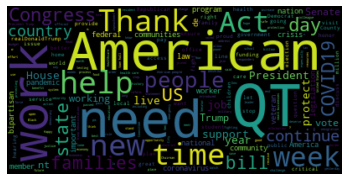

In [12]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2: Length and Word Count

In [13]:
congress_tweets['tweet_len'] = congress_tweets['text_deEmojify'].apply(len)
congress_tweets['word_count'] = congress_tweets['text_deEmojify'].apply(lambda x: len(str(x).split()))

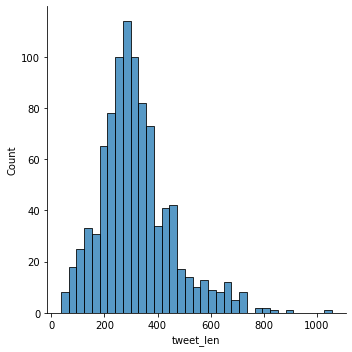

In [14]:
sns.displot(congress_tweets, x="tweet_len")
plt.show()

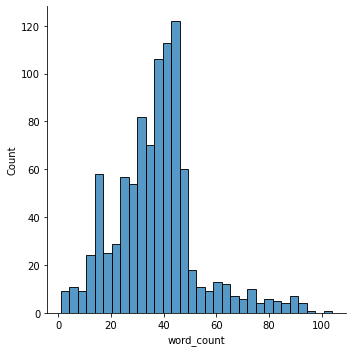

In [15]:
sns.displot(congress_tweets, x="word_count")
plt.show()

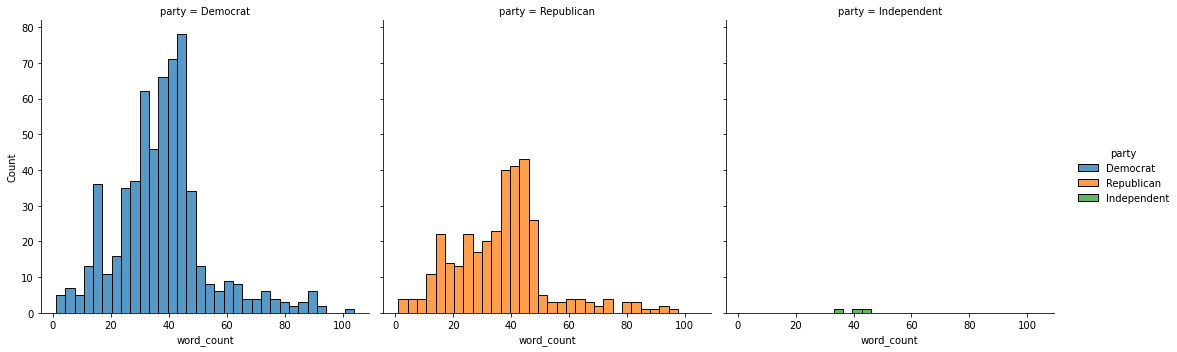

In [16]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

### Topic Modeling

In [17]:
X = congress_tweets['text_deEmojify']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [18]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [19]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [20]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
  work need week covid19 help jobs de country community happy thank congress americans care district people qt time trump

Topic #1:
  new health house qt “ president trump american administration ” workers congress covid19 continue work democrats veterans families week

Topic #2:
  act americans help new house qt work trump system president care important ’ ago health people thank senate 2020census

Topic #3:
  qt trump time need people families covid19 coronavirus president relief new act thank house nt read law — american

Topic #4:
american people   help thank president – county crisis work sen local great bill nation time act families community house



In [21]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03834265, 0.03858455, 0.84580787, 0.03860847, 0.03865646],
       [0.81537903, 0.04575907, 0.04607881, 0.04581743, 0.04696567],
       [0.03570333, 0.85667382, 0.03622495, 0.03575626, 0.03564164],
       ...,
       [0.04083828, 0.04088593, 0.83636491, 0.04095678, 0.04095411],
       [0.04086538, 0.04136615, 0.83557333, 0.04124446, 0.04095068],
       [0.03656907, 0.0366098 , 0.8531591 , 0.03687188, 0.03679015]])

In [22]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,level_0,index,tweet_id,screen_name,datetime,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count
0,0.038343,0.038585,0.845808,0.038608,0.038656,217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,...,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"[Thank, testifying, Mr, Blake, QT, JRBlake, Re...",233,30
1,0.815379,0.045759,0.046079,0.045817,0.046966,258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,...,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"[My, Twitter, Town, Hall, healthcare, begun, I...",115,20
2,0.035703,0.856674,0.036225,0.035756,0.035642,50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,...,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"[Scipio, Jones, ‘, fight, civil, rights, equal...",279,49
3,0.047693,0.808052,0.048647,0.047677,0.047931,205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,...,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"[There, better, time, ActOnClimate, EarthDay, ...",158,27
4,0.041472,0.041521,0.042081,0.041768,0.833157,85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,...,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[I, understand, VA, problems, recruiting, qual...",202,32


In [23]:
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.306694
Republican     0.178090
Democrat       0.166231
Name: 0, dtype: float64
party
Democrat       0.184993
Republican     0.181577
Independent    0.036185
Name: 1, dtype: float64
party
Republican     0.220183
Democrat       0.200140
Independent    0.036215
Name: 2, dtype: float64
party
Independent    0.306977
Democrat       0.240644
Republican     0.190992
Name: 3, dtype: float64
party
Independent    0.313929
Republican     0.229158
Democrat       0.207992
Name: 4, dtype: float64


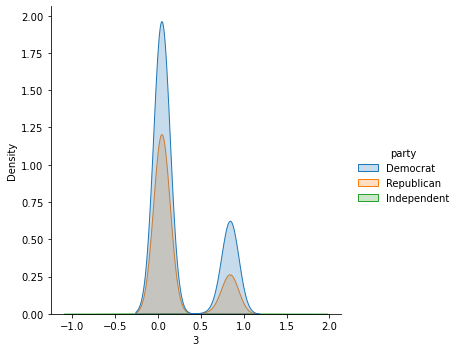

In [24]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "party", kind = 'kde', fill = 'true')
plt.show()

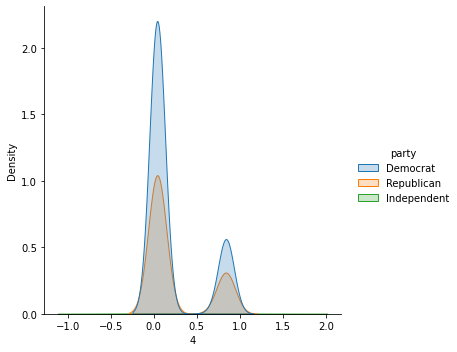

In [25]:
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## 5. Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 5.1: Tammy Duckworth (D-IL) vs. Ted Cruz (R-TX)

In [ ]:
#congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
#congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
#congress_tweets.head()

In [26]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

#Ted Cruz and Tammy Duckworth Tweets
cruz_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Cruz']
duckworth_tweets = congress_tweets[congress_tweets.name_wikipedia == "Tammy Duckworth"]

#Combining dataframes
cruz_duck_df = [cruz_tweets, duckworth_tweets]
cruz_duck_tweets = pd.concat(cruz_duck_df)

#Polarity and Subjectivity
cruz_duck_tweets['polarity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cruz_duck_tweets['subjectivity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

cruz_duck_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity
820487,820487,1.279160e+18,SenTedCruz,2020-07-03T17:11:55-04:00,"This weekend, we celebrate the birth of our na...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","This weekend, we celebrate the birth of our na...",This weekend celebrate birth nation gift indep...,246,41,0.000000,0.000000
811947,811947,1.256300e+18,SenTedCruz,2020-05-01T15:29:55-04:00,RT @EricTrump Challenge accepted @SeanHannity!...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",RT @EricTrump Challenge accepted @SeanHannity!...,EricTrump Challenge accepted SeanHannity Along...,703,92,0.500000,0.600000
797929,797929,1.220850e+18,SenTedCruz,2020-01-24T18:29:25-05:00,My thoughts &amp; prayers are with the familie...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",My thoughts &amp; prayers are with the familie...,My thoughts prayers families 2 Houstonians liv...,688,84,-0.059524,0.238095
787860,787860,1.187810e+18,SenTedCruz,2019-10-25T15:26:23-04:00,It’s time for Congress and the American people...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",It’s time for Congress and the American people...,It time Congress American people hear directly...,251,44,0.150000,0.225000
760177,760177,1.088950e+18,SenTedCruz,2019-01-25T18:47:06-05:00,"Yesterday, I fought hard to immediately pay ev...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","Yesterday, I fought hard to immediately pay ev...",Yesterday I fought hard immediately pay single...,248,37,-0.090774,0.338988


### Polarity

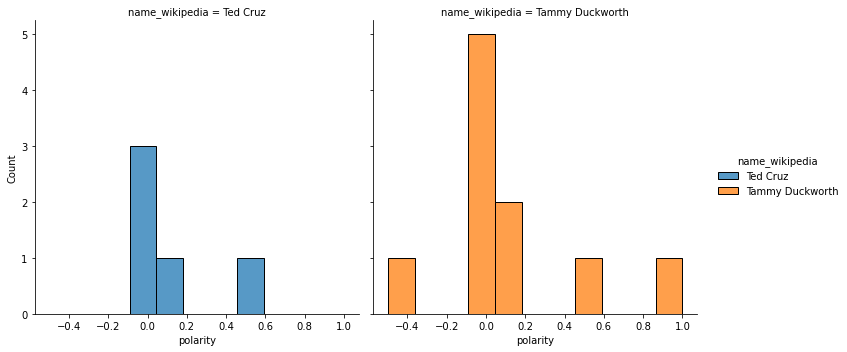

In [27]:
sns.displot(cruz_duck_tweets, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest polarity

**Tammy Duckworth:**

In [28]:
duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in duckworth_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

We can do so much more to help survivors of breast cancer return to health and achieve the best quality of life. That's why I'm introducing the Breast Cancer Patient Equity Act with @lisamurkowski, @RepJudyChu &amp; @RepWalorski https://www.duckworth.senate.gov/news/press-releases/-duckworth-murkowski-chu-and-walorski-re-introduce-bipartisan-bicameral-bill-to-expand-coverage-for-breast-cancer-patients-and-survivors



<ipython-input-28-647af7a0291e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


**Ted Cruz:**

In [29]:
cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in cruz_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-29-0809f2072989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


### Tweets with the smallest polarity

**Tammy Duckworth:**

In [30]:
for tweets in duckworth_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Three years ago today, days after the horrific #PulseShooting, dozens of Congresspeople led by civil rights hero @repjohnlewis gathered on the House floor to stage an historic, 25-hour sit-in demanding a House vote to #EndGunViolence &amp; an end to GOP efforts to block those votes.



**Ted Cruz:**

In [31]:
for tweets in cruz_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Yesterday, I fought hard to immediately pay every single essential federal employee – every essential employee at the Coast Guard, the TSA, air traffic controllers, Border Patrol agents, ICE agents, FBI agents, and those throughout law enforcement.



### Subjectivity

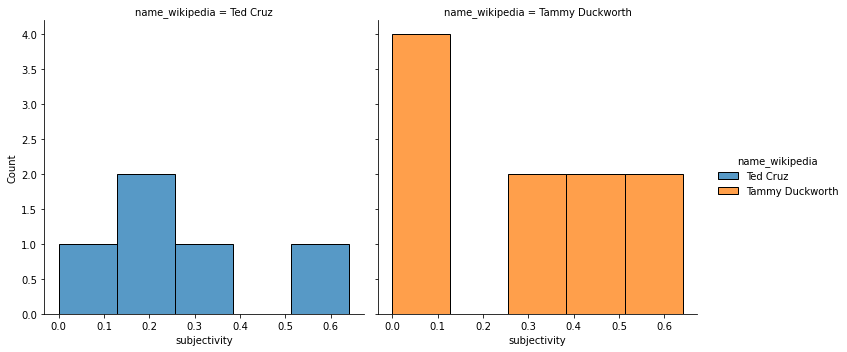

In [32]:
sns.displot(cruz_duck_tweets, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest subjectivity

**Tammy Duckworth:**

In [34]:
duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in duckworth_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweets + "\n")

I will keep working to ensure every family in America – no matter where they live – has access to clean and safe drinking water, and I’m proud to introduce this bill with @RepDanKildee to better protect our children from lead-contaminated water. https://www.duckworth.senate.gov/news/press-releases/07/11/2019/duckworth-kildee-re-introduce-legislation-to-help-protect-families-from-lead-contaminated-water



<ipython-input-34-5401f4840256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


**Ted Cruz**

In [35]:
cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in cruz_tweets.nlargest(1, "subjectivity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-35-d66c643106dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### Tweets with the smallest subjectivity

**Tammy Duckworth:**

In [36]:
for tweets in duckworth_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

After my father lost his job when I was a teenager, food stamps and reduced price meals at school helped keep me from going hungry. I wasn’t alone, either: millions of children across our nation rely on #SchoolBreakfast and other nutritious meals too.



**Ted Cruz:**

In [37]:
for tweets in cruz_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

This weekend, we celebrate the birth of our nation and the gift of independence. Throughout the history of mankind, freedom has been the exception. And yet, here in America, freedom has been delivered and defended for every man, women, and child.



### Sujectivity vs. Polarity

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

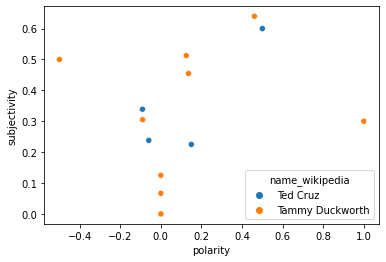

In [38]:
sns.scatterplot(x = cruz_duck_tweets['polarity'], y = cruz_duck_tweets['subjectivity'], hue = cruz_duck_tweets['name_wikipedia'])

### 5.2: Party Affiliation and Bodies of Congress

### Polarity 

In [40]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

**Party Affiliation**

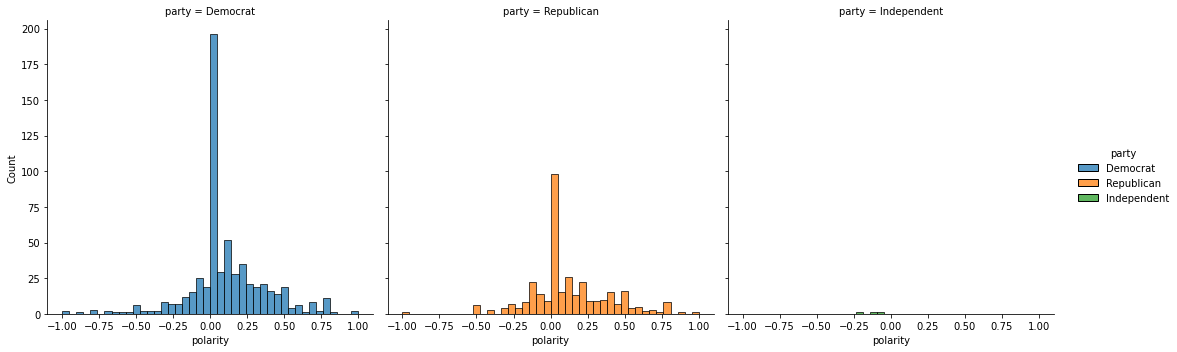

In [42]:
#By Party
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

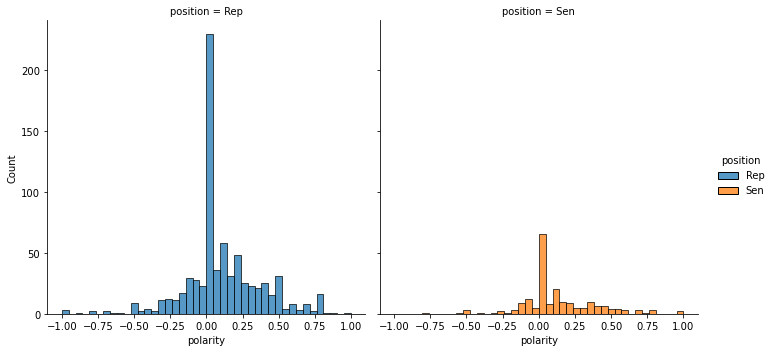

In [43]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

### Subjectivity

In [44]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

**Party Affiliation**

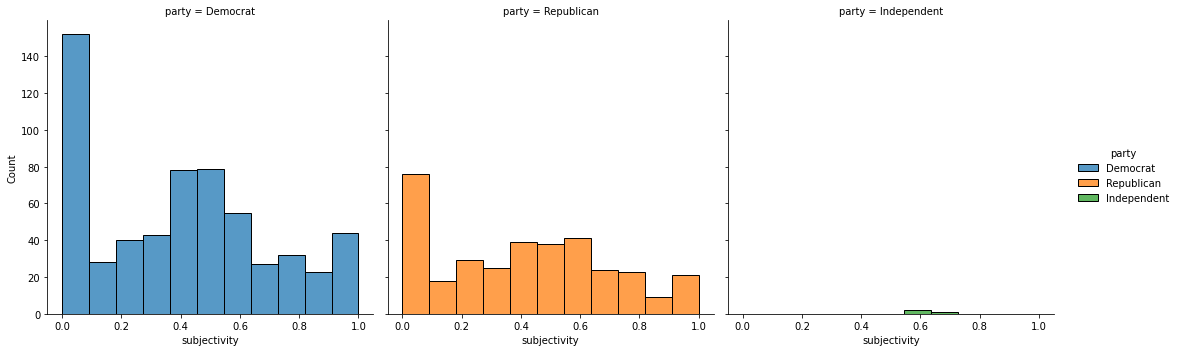

In [45]:
#by party
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

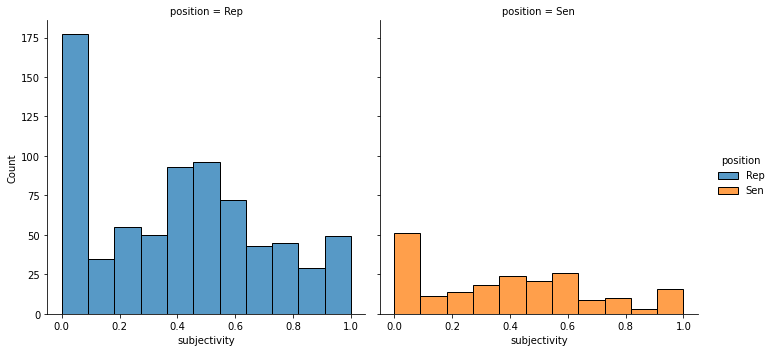

In [46]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## 6. Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [ ]:
# Engineered Features
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [ ]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]


In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)



tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)

In [ ]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
nmf = NMF(n_components=5, init='random', random_state=0)
nmf = nmf.fit(dense_matrix)



tf_feature_names = tf.get_feature_names()
print_top_words(nmf, tf_feature_names, 20)

nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

In [ ]:
congress_tweets.columns

In [ ]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date',
       'gender', 'state','party', 'trump_2016_state_share', 'clinton_2016_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

In [ ]:
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features']

### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
...

In [ ]:
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))

In [ ]:
bow_matrix = bow_vector.fit_transform(congress_tweets['deEmojify'][0:5])

#bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

In [ ]:
bow_matrix.todense()

In [ ]:
feature_names = bow_vector.get_feature_names()
feature_names[0:10]

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## 7. Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## 8. Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**